https://machinelearningmastery.com/how-to-develop-convolutional-neural-networks-for-multi-step-time-series-forecasting/

https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

https://unit8.com/resources/darts-time-series-made-easy-in-python/

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html


# 1. Establecimiento del ambiente de desarrollo y ejecución.

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint
import os, time, random, math
import time
import copy

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

No hay GPU, toca correr todo en CPU


device(type='cpu')

In [ ]:
def reset_seed():
    random_seed = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
reset_seed()

In [ ]:
def plot_losses(train_losses, val_losses=None):
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses)
    if val_losses is not None:
        ax.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    _=plt.show()

Obtener el archivo con los datos de base

In [ ]:
# Si estamos en COLAB

!wget -O 'household_power_consumption.zip' 'https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip'
!unzip 'household_power_consumption.zip'
filename = 'household_power_consumption.txt'
dataset_raw_file = filename
dataset_file = 'household_power_consumption.txt'

--2025-01-22 21:39:40--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip’

household_power_con     [  <=>               ]  19.68M  61.1MB/s    in 0.3s    

2025-01-22 21:39:40 (61.1 MB/s) - ‘household_power_consumption.zip’ saved [20640916]

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: household_power_consumption.txt  


In [ ]:
# Si estamos en conda local

#conda install -c menpo wget
# import wget
# url = 'https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip'
# output_file = 'C:/Temp/household_power_consumption.zip'
# zip_file_path = wget.download(url, out=output_file)
# print(zip_file_path)

# import zipfile
# extract_to = 'C:/Temp/'
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)
# dataset_raw_file = 'C:/Temp/household_power_consumption.txt'
# dataset_file = 'C:/Temp/household_power_consumption.csv'

In [ ]:
# load all data
df = pd.read_csv(dataset_raw_file,
                 sep=';', header=0,
                 low_memory=False,
                 #parse_dates={'datetime':[0,1]},
                 #index_col=['datetime']
                )
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


Vemos que tenemos un valor por cada minuto.
Es decir que en un día hay 24*60=1440 registros.

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.insert(0, 'Datetime', df.pop('Datetime'))
df = df.drop('Date', axis=1)
df = df.drop('Time', axis=1)

In [ ]:
# Seteamos el tiempo como índice del dataframe
df.set_index('Datetime', inplace=True)
df.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0


In [ ]:
df.tail(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0
2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0


In [ ]:
df.replace('?', np.nan, inplace=True)
columns_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[columns_to_convert] = df[columns_to_convert].astype('float32')
df.dtypes

,0
Global_active_power,float32
Global_reactive_power,float32
Voltage,float32
Global_intensity,float32
Sub_metering_1,float32
Sub_metering_2,float32
Sub_metering_3,float32


Remplazamos los valores faltantes por el valor que se tenía el día anterior

In [ ]:
df.describe(include='all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237144e-01,2.408399e+02,4.627760e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057005e+00,1.128308e-01,4.114049e+00,4.440444e+00,6.104221e+00,5.758089e+00,8.458705e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if np.isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

fill_missing(df.values)

In [ ]:
df.describe(include='all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237144e-01,2.408399e+02,4.627760e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057005e+00,1.128308e-01,4.114049e+00,4.440444e+00,6.104221e+00,5.758089e+00,8.458705e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


A partir del conocimiento de negocio, nos informan que hace falta una variable que indique el restante del poder, y nos explican que podemos crearla a partir del valor global de poder y de los otros 3 valores de consumo.

In [ ]:
values = df.values
df['Sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [ ]:
df.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333336


In [ ]:
df.tail(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Datetime,,,,,,,,
2010-11-26 21:01:00,0.934,0.0,239.699997,3.8,0.0,0.0,0.0,15.566667
2010-11-26 21:02:00,0.932,0.0,239.550003,3.8,0.0,0.0,0.0,15.533334


Guardamos el dataset preparado, que contiene 8 variables numéricas

In [ ]:
# save updated dataset
df.to_csv(dataset_file)

# 2. Sets de entrenamiento y de validación

Queremos responder a la pregunta: dado el consumo reciente de energía, ¿cuál será el **consumo diario** de energía para **cada día de la siguiente semana**?

Vemos que los registros van desde el 16 de diciembre de 2006 hasta el 26 de noviembre de 2010.
Vamos a empezar por cortar los primeros registros, para que el dataset empiece en el 17 de diciembre de 2006 y el primer día del dataset completo y que sea un domingo (comienzo de semana).
El último día que consideraremos será el 20 de noviembre de 2010, un sábado, para finalizar la semana en curso.

En este momento tenemos una serie de tiempo con granularidad temporal de un minuto. Par simplificar el problema, dada la pregunta, vamos a remuestrar los datos definiendo una granularidad mas gruesa que corresponda con un periodo de tiempo diario. Es decir, vamos a sumar los consumos de todos los 1440 minutos de un día para crear cada nuevo registro.
Utilizamos el método `resample` de pandas sobre el índice de tipo Timestamp, indicando la granularidad diaria `'D'`.

In [ ]:
dataset = pd.read_csv(dataset_file, header=0, index_col=['Datetime'])
# resample data to daily
daily_groups = df.resample('D')
daily_data = daily_groups.sum()
print(daily_data.shape)
daily_data.head(2)

(1442, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969


In [ ]:
daily_data.tail(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Datetime,,,,,,,,
2010-11-25,1431.163940,116.127998,347812.21875,6004.000000,1076.0,426.0,5072.0,17278.732422
2010-11-26,1488.104004,120.826004,303487.56250,6259.799805,1080.0,385.0,9989.0,13347.733398


In [ ]:
daily_data.to_csv(dataset_file)

Vamos a tomar los registros de 2010 como test set, empezando el 3 de enero, el primer domingo del año.

In [ ]:
daily_data.iloc[1113:1115, :]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Datetime,,,,,,,,
2010-01-02,1308.836060,199.416000,352090.46875,5488.000000,801.0,298.0,6424.0,14290.933594
2010-01-03,2083.454102,191.610001,350992.12500,8703.599609,3842.0,4920.0,10074.0,15888.233398


Tenemos entonces que el último registro del training set debería ser el de 1114avo (índice 1113). Dado que se va a pronosticar los siguientes 7 días de la semana, la última ventana de features con valores predictivos terminará en el registro con índica 1106.

Vamos a crear una subclase de `Dataset` para poder obtener las instancias de entrenamiento y validación de una tarea de forecasting sobre las series de tiempo multivariadas, en la que se quiera pronosticar un solo valor en el futuro. Esta clase recibirá los siguientes parámetros en el momento de su instanciación:

- **dataset**: tensor de rango 2, con el primer eje temporal y el segundo conteniendo las variables.
- **target**: tensor de rango 1 con la variable que se desea predecir
- **history_size**: el tamaño de la ventana de valores predictores históricos (variables independientes) a considerar. Si **step** es mayor a 1, no todos los datos del histórico se tendrán en cuenta.
- **target_size**: numero de pasos en el futuro después del fin de la ventana a considerar para definir los valores dependientes. En el caso de que **single_step** sea False, solo se considera el valor que esté a **target_size**+1 de distancia del final de la ventana de valores predictores históricos. En el caso de que **single_step** sea True, se considerarán todos los valores desde el final de la ventana histórica hasta **target_size**+1 (no incluido).
- **step**: permite establecer como se escogen los valores secuenciales de la ventna definida por **history_size**, en terminos de los saltos internos dentro de la misma, de un valor escogido al siguiete. Si su valor es 1, se escogen todos los valores de la ventana. Si su valor es 2, se escoge el primer valor de la ventana, el tercero, el quinto, y así sucesivamente. Esta funcionalidad puede ser útil si se considera que los valores de la serie varían poco.
- **single_step**: `False` por defecto. Indica si se va a considerar un único valor futuro a predecir o una ventana de valores a predecir.

Es importante notar que en Pytorch los tensores de entrada y salida de una capa convolucional siguen la convención *channel-first*. Por lo que es necesario cambiar la organización de los ejes de los tensores. Ver https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html.


In [ ]:
class SerieTiempoMultivariadaDataset(Dataset):
    def __init__(self, dataset, target,
                 history_size, target_size, step, single_step=False):
        if dataset.shape[0] !=  target.shape[0]:
            raise Exception("El tamaño de los datasets no coincide")

        data = []
        labels = []

        start_index = history_size
        end_index = len(dataset) - target_size +1

        for i in range(start_index, end_index):
            # ventana histórica
            indices_history = range(i-history_size, i, step)
            data.append(dataset.iloc[indices_history, :])

            # ventana futura
            if single_step:
                labels.append([target.iloc[i+target_size]])
            else:
                indices_future = range(i, i+target_size, step)
                labels.append(target.iloc[indices_future])

        self.data = torch.FloatTensor(np.array(data))
        self.data = self.data.permute(0, 2, 1)
        self.labels = torch.FloatTensor(np.array(labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (idx >= len(self.data)) or (idx < 0):
            raise Exception("Out of bounds: idx=", idx)
        return self.data[idx], self.labels[idx]
    def get_labels(self):
        return self.labels
    def get_data(self):
        return self.data

In [ ]:
daily_data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Sub_metering_4'],
      dtype='object')

Para entender el funcionamiento de esta clase, analicemos un caso en el que definimos que:
- se quiere pronosticar la variable 'Global_active_power', por lo que **target**=`daily_data[:, 0]`
- con un dataset de base que considere los registros del 1 al 1113  (training set)
- una ventana temporal de 1 semana (**history_size** de 7 pasos de tiempo diarios) como lags de entrenamiento
- tomando todos los valores consecutivos sin saltos (un **step** de 1)
- para predecir los 7 dias siguientes sin salto de tiempo futuro (**future_target** de 7, y **single_step**=False)

In [ ]:
past_history = 7 # La última semana
future_target = 7 # Queremos predecir el valor en los siguientes 7 días
STEP = 1 # Queremos todos los días sin saltos
primer_dia = 1
ultimo_dia = 1113 #20
dataset_train = SerieTiempoMultivariadaDataset(
    dataset=daily_data.iloc[primer_dia:ultimo_dia+1, :],
    target=daily_data.iloc[primer_dia:ultimo_dia+1, 0],
    history_size=past_history,
    target_size=future_target,
    step=STEP,
    single_step=False)

In [ ]:
dataset_train[len(dataset_train)-1]

(tensor([[1.1442e+03, 2.0350e+03, 1.8880e+03, 1.4552e+03, 2.9059e+03, 2.1276e+03,
          2.1836e+03],
         [1.2210e+02, 1.7195e+02, 1.5336e+02, 1.3542e+02, 2.0366e+02, 1.9238e+02,
          1.6088e+02],
         [3.5631e+05, 3.5483e+05, 3.5386e+05, 3.5551e+05, 3.5400e+05, 3.5077e+05,
          3.4915e+05],
         [4.6720e+03, 8.3208e+03, 7.7266e+03, 5.9348e+03, 1.1943e+04, 8.8238e+03,
          9.0812e+03],
         [1.2370e+03, 3.2930e+03, 0.0000e+00, 1.1430e+03, 5.1840e+03, 3.3710e+03,
          1.1860e+03],
         [3.1300e+02, 2.8200e+02, 2.8500e+02, 2.8400e+02, 5.5750e+03, 3.8950e+03,
          4.2940e+03],
         [7.7950e+03, 1.1473e+04, 1.5829e+04, 1.1205e+04, 1.5198e+04, 1.4288e+04,
          1.6047e+04],
         [9.7244e+03, 1.8868e+04, 1.5353e+04, 1.1621e+04, 2.2475e+04, 1.3907e+04,
          1.4867e+04]]),
 tensor([2195.4519, 2094.0979, 2047.9680, 2451.1101, 2211.8921, 1224.2520,
         1308.8361]))

In [ ]:
len(dataset_train)

1100

Vemos que nuestro dataset de entrenamiento tiene 1100 instancias

In [ ]:
# ventana historica que se considerará para la predicción
dataset_train[0][0].shape

torch.Size([8, 7])

In [ ]:
# ventana futura con los valores a predecir
dataset_train[0][1].shape

torch.Size([7])

Cada instancia está compuesta por una dupla de tensores:
- **features**: un tensor de rango 2, con 8 valores de las variables de consumo energético, y una señal con 7 pasos de tiempo (1 por día).
- **labels**: un tensor de rango 1, con los valores de la única variable variable objetivo para los 7 días de la semana siguiente al último paso de tiempo de **features**.

Podemos comprobar que en el dataset la primera instancia en los **features** contiene los valores de los pasos de tiempo 1 al 7 inclusive, saltándose el primer paso de tiempo 0, que corresponde a lo esperado. Además podemos ver que la variable objetivo contiene los 7 valores de la semana siguiente.

In [ ]:
dataset_train[0]

(tensor([[3.3905e+03, 2.2038e+03, 1.6662e+03, 2.2257e+03, 1.7166e+03, 2.3413e+03,
          4.7734e+03],
         [2.2601e+02, 1.6179e+02, 1.5094e+02, 1.6100e+02, 1.4417e+02, 1.8691e+02,
          2.2147e+02],
         [3.4573e+05, 3.4737e+05, 3.4848e+05, 3.4892e+05, 3.4662e+05, 3.4731e+05,
          3.4580e+05],
         [1.4399e+04, 9.2472e+03, 7.0940e+03, 9.3130e+03, 7.2386e+03, 9.8970e+03,
          2.0200e+04],
         [2.0330e+03, 1.0630e+03, 8.3900e+02, 0.0000e+00, 1.7650e+03, 3.1510e+03,
          2.6690e+03],
         [4.1870e+03, 2.6210e+03, 7.6020e+03, 2.6480e+03, 2.6230e+03, 3.5000e+02,
          4.2500e+02],
         [1.3341e+04, 1.4018e+04, 6.1970e+03, 1.4063e+04, 1.0421e+04, 1.1131e+04,
          1.4726e+04],
         [3.6947e+04, 1.9028e+04, 1.3132e+04, 2.0385e+04, 1.3801e+04, 2.4390e+04,
          6.1736e+04]]),
 tensor([2550.0120, 2743.1201, 3934.1101, 1528.7600, 2072.6379, 3174.3921,
         2789.3020]))

In [ ]:
dataset[1:15][['Global_active_power']]

,Global_active_power
Datetime,
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666
2006-12-16 17:29:00,3.520
2006-12-16 17:30:00,3.702
2006-12-16 17:31:00,3.700
2006-12-16 17:32:00,3.668
2006-12-16 17:33:00,3.662


Podemos además comprobar que el último valor de los labels a pronosticar corresponde con el valor del 2 de enero de 2010.

De la misma manera creamos el test set.

In [ ]:
past_history = 7 # La última semana
future_target = 7 # Queremos predecir el valor en los siguientes 7 días
STEP = 1 # Queremos todos los días sin saltos
primer_dia = 1114
ultimo_dia = len(daily_data) - 7
dataset_test = SerieTiempoMultivariadaDataset(dataset=daily_data.iloc[primer_dia:ultimo_dia+1, :], target=daily_data.iloc[primer_dia:ultimo_dia+1, 0],
                                                 history_size=past_history, target_size=future_target,
                                                 step=STEP, single_step=False)

In [ ]:
dataset_test[len(dataset_test)-1]

(tensor([[1.6738e+03, 1.8255e+03, 2.0221e+03, 1.9465e+03, 1.7736e+03, 1.8368e+03,
          2.0232e+03],
         [1.7498e+02, 1.4566e+02, 1.5467e+02, 1.5347e+02, 1.5219e+02, 1.5114e+02,
          1.6218e+02],
         [3.4335e+05, 3.4235e+05, 3.4241e+05, 3.4428e+05, 3.4377e+05, 3.4393e+05,
          3.4464e+05],
         [7.1510e+03, 7.7374e+03, 8.6198e+03, 8.2320e+03, 7.5680e+03, 7.8262e+03,
          8.5242e+03],
         [1.0260e+03, 1.0870e+03, 2.0970e+03, 1.0260e+03, 3.4240e+03, 2.0540e+03,
          1.0510e+03],
         [6.2100e+02, 5.5500e+02, 5.8300e+02, 5.8580e+03, 2.2160e+03, 4.8900e+02,
          5.8900e+02],
         [6.9430e+03, 1.3038e+04, 1.2500e+04, 1.3308e+04, 6.2590e+03, 1.0308e+04,
          1.3853e+04],
         [1.9307e+04, 1.5746e+04, 1.8522e+04, 1.2250e+04, 1.7661e+04, 1.7763e+04,
          1.8227e+04]]),
 tensor([2038.3920, 1747.3820, 1509.7480, 1582.0320, 1652.1520, 1570.4000,
         2197.0061]))

In [ ]:
daily_data.iloc[-20:-6, 0]

,Global_active_power
Datetime,
2010-11-07,1673.816040
2010-11-08,1825.540039
2010-11-09,2022.098022
2010-11-10,1946.534058
2010-11-11,1773.592041
2010-11-12,1836.822021
2010-11-13,2023.173950
2010-11-14,2038.391968
2010-11-15,1747.381958


Podemos comprobar que el último valor de las etiquetas a predecir en el test set corresponde al sábado 20 de noviembre de 2010.

# 3. Modelado univariado de pronóstico de ventana futura en una sola pasada

Vamos inicialmente a crear un único modelo que dados los 7 días anteriores de la primera variable, pronostique los 7 valores de la misma variable los 7 días siguientes.

Creamos los datasets y dataloaders correspondientes

In [ ]:
past_history = 7 # La última semana
future_target = 7 # Queremos predecir el valor en los siguientes 7 días
STEP = 1 # Queremos todos los días sin saltos
primer_dia = 1
ultimo_dia = 1113
dataset_train = SerieTiempoMultivariadaDataset(dataset=daily_data.iloc[primer_dia:ultimo_dia+1, 0:1], target=daily_data.iloc[primer_dia:ultimo_dia+1, 0],
                                                 history_size=past_history, target_size=future_target,
                                                 step=STEP, single_step=False)

In [ ]:
past_history = 7 # La última semana
future_target = 7 # Queremos predecir el valor en los siguientes 7 días
STEP = 1 # Queremos todos los días sin saltos
primer_dia = 1114
ultimo_dia = len(daily_data) - 7
dataset_test = SerieTiempoMultivariadaDataset(dataset=daily_data.iloc[primer_dia:ultimo_dia+1, 0:1], target=daily_data.iloc[primer_dia:ultimo_dia+1, 0],
                                                 history_size=past_history, target_size=future_target,
                                                 step=STEP, single_step=False)

Vamos ahora a crear un `DataLoader` para poder obtener batches de entrenamiento y test.
El `DataLoader` de entrenamiento lo barajamos con `shuffle=True`, para no introducir sesgos de orden de presentación de instancias de aprendizale; el de test no requiere de ese tratamiento.

In [ ]:
BATCH_SIZE=32

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Verifiquemos como sería un batch

In [ ]:
batch_features, batch_labels = next(iter(train_dataloader))

In [ ]:
batch_features.shape

torch.Size([32, 1, 7])

In [ ]:
batch_labels.shape

torch.Size([32, 7])

Vemos que un batch de entrenamiento utiliza un tensor de rango 3 (instancias, features, pasos de tiempo), y un tensor de rango 2 (instancias, valores a pronósticar).

Como tenemos alrededor de 1100 instancias de entrenamiento (pocas instancias), y no podemos utilizar transfer learning para esta tarea tan particular, vamos a tener que crear modelos convolucionales sencillos.

In [ ]:
class PronosticoUnivariado(nn.Module):
    def __init__(self, ventana_futura=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding="valid")
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=16*2, out_features=10)
        self.linear2 = nn.Linear(in_features=10, out_features=ventana_futura)

    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        logits = self.linear2(x)

        return logits

In [ ]:
modelo_univariado_ventana_onepass = PronosticoUnivariado(ventana_futura=7)
modelo_univariado_ventana_onepass

PronosticoUnivariado(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=valid)
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=7, bias=True)
)

In [ ]:
for param in modelo_univariado_ventana_onepass.parameters():
    print(f"{param.shape}")

torch.Size([16, 1, 3])
torch.Size([16])
torch.Size([10, 32])
torch.Size([10])
torch.Size([7, 10])
torch.Size([7])


In [ ]:
modelo_univariado_ventana_onepass.to(DEVICE) # OJO, es necesario que el modelo esté en el mismo dispositivo del resto de tensores con los que se interactúa.
summary(modelo_univariado_ventana_onepass, input_size=(1, 7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]              64
         MaxPool1d-2                [-1, 16, 2]               0
           Flatten-3                   [-1, 32]               0
            Linear-4                   [-1, 10]             330
            Linear-5                    [-1, 7]              77
Total params: 471
Trainable params: 471
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Vamos a pasar un batch a través del modelo

In [ ]:
batch_features.shape

torch.Size([32, 1, 7])

In [ ]:
batch_preds=modelo_univariado_ventana_onepass(batch_features)
batch_preds.shape

torch.Size([32, 7])

In [ ]:
modelo_univariado_ventana_onepass.to(DEVICE) # OJO, es necesario que el modelo esté en el mismo dispositivo del resto de tensores con los que se interactúa.
summary(modelo_univariado_ventana_onepass, input_size=(1, 7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]              64
         MaxPool1d-2                [-1, 16, 2]               0
           Flatten-3                   [-1, 32]               0
            Linear-4                   [-1, 10]             330
            Linear-5                    [-1, 7]              77
Total params: 471
Trainable params: 471
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Para evaluar el desempeño del modelo necesitamos comparar los 7 valores predichos con los 7 valores reales. Las funciones de loss se encargan de comparar los pares de valores y de agregar las losses individuales.
Lo ilustramos a continuación:

In [ ]:
preds = torch.tensor([[2.5, 0.0, 2.1, 1.5, 0.7, 0.8, 3.0],
                            [1.2, 3.4, 0.5, 2.3, 1.1, 1.0, 2.0]])
targets = torch.tensor([[3.0, 0.0, 2.0, 1.0, 0.5, 0.8, 3.0],
                        [1.0, 3.5, 0.5, 2.0, 1.0, 1.2, 2.5]])

# Comparar los valores
loss_fn = nn.MSELoss()
loss = loss_fn(preds, targets)
print(loss.item())

0.07071428745985031


Ahora hagamos el proceso a mano

In [ ]:
mse_acumulado = 0
for semana_target, semana_pred in zip(targets, preds):
    print(semana_target)
    print(semana_pred)
    diferencias = semana_target - semana_pred
    diferencias_2 = diferencias ** 2
    print(diferencias_2)
    mse = diferencias_2.mean()
    print(mse)
    mse_acumulado += mse
print(mse_acumulado/len(targets))


tensor([3.0000, 0.0000, 2.0000, 1.0000, 0.5000, 0.8000, 3.0000])
tensor([2.5000, 0.0000, 2.1000, 1.5000, 0.7000, 0.8000, 3.0000])
tensor([0.2500, 0.0000, 0.0100, 0.2500, 0.0400, 0.0000, 0.0000])
tensor(0.0786)
tensor([1.0000, 3.5000, 0.5000, 2.0000, 1.0000, 1.2000, 2.5000])
tensor([1.2000, 3.4000, 0.5000, 2.3000, 1.1000, 1.0000, 2.0000])
tensor([0.0400, 0.0100, 0.0000, 0.0900, 0.0100, 0.0400, 0.2500])
tensor(0.0629)
tensor(0.0707)


Vamos ahora a crear la función de entrenamiento.

In [ ]:
def train_model(modelo, train_dataset, train_batch_size=64, learning_rate = 1e-3, epocas=30, loss_fn=nn.MSELoss(), val_split=0, early_stopping_loss_val_patience=-1, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento.

    :modelo:
        instancia creada del modelo a entrenar
    :train_dataset:
        instancia de Dataset con los datos de entrenamiento
    :train_batch_size:
        tamaño del batch size de entrenamiento
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :loss_fn:
        función de pérdida a utilizar. Si no se especifica, se usa MSELoss
    :val_split:
        porcentaje del dataset de entrenamiento dedicado a la validación, su valor será limitado al intervalo [0 (sin validación), 0.5]
    :early_stopping_loss_val_patience:
        número de épocas de paciencia a esperar una mejora del val loss antes de suspender el entrenamiento. -1 implica que no se aplica el early stopping
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y los arrays con los valores de losses del training y test dataset después de cada época.
    """

    reset_seed()

    # Gestión de los loaders de training y validation
    if val_split > 0.5:
        val_split=0.5

    if val_split < 0:
        val_split=0

    if val_split > 0:
        num_training_instances = int(len(train_dataset)*(1-val_split))
        num_validation_instances = len(train_dataset) - num_training_instances
        print(f"val_split: {val_split}, num_training_instances {num_training_instances}, num_validation_instances {num_validation_instances}")
        training_subset, validation_subset = torch.utils.data.random_split(
            train_dataset, [num_training_instances, num_validation_instances])

        train_loader = torch.utils.data.DataLoader(
            training_subset, batch_size=train_batch_size, shuffle=True, num_workers=2)
        validation_loader = torch.utils.data.DataLoader(
            validation_subset, batch_size=64, num_workers=2)

    else :
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)


    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    val_losses = [0] * epocas

    min_loss = np.Inf
    best_model = None
    num_epocas_patience = 0


    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE).float()
            # Generar las predicciones
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)
            # print(f"batch_preds: {batch_preds}")
            # print(f"labels: {batch_labels}")

        # se normalizan el loss y el accuracy del training set
        train_losses[epoca] /= len(train_loader.dataset)

        if val_split > 0:
            # se desactiva la diferenciación automática para la inferencia sobre el val set
            modelo.eval()
            with torch.no_grad():
                for batch_features, batch_labels in validation_loader:
                    # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                    batch_features = batch_features.to(DEVICE)
                    batch_labels = batch_labels.to(DEVICE).float()
                    # Generar las predicciones
                    batch_preds = modelo(batch_features)
                    # Comparar con las realidades a partir del loss function
                    loss = loss_fn(batch_preds, batch_labels)
                    # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                    val_losses[epoca] += loss.item() * batch_labels.size(0)
            # se normalizan el loss y el accuracy del val set
            val_losses[epoca] /= len(validation_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            if val_split > 0:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")

                # model checkpoint
                if val_losses[epoca] < min_loss:
                    best_model=copy.deepcopy(modelo)
                    torch.save(modelo, "best_model.pth")
                    print(f"Se mejoró el val loss de {min_loss} a {val_losses[epoca]}")
                    min_loss = val_losses[epoca]
                    num_epocas_patience = 0
                else:
                    num_epocas_patience +=1

                if early_stopping_loss_val_patience >-1 and num_epocas_patience > early_stopping_loss_val_patience:
                    print(f"----- Se sobrepasó el patience del val loss del early stopping {num_epocas_patience})")
                    break

            else:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")

                # model checkpoint
                if train_losses[epoca] < min_loss:
                    torch.save(modelo, "best_model.pth")
                    print(f"Se mejoró el train loss de {min_loss} a {train_losses[epoca]}")
                    min_loss = train_losses[epoca]

    if val_split > 0:
        return best_model, train_losses, val_losses
    else:
        return modelo, train_losses

In [ ]:
modelo_univariado_ventana_onepass = PronosticoUnivariado(ventana_futura=7)
best_model, train_losses, val_losses = train_model(modelo_univariado_ventana_onepass,
                                                   dataset_train,
                                                   train_batch_size=32, learning_rate = 0.0015, epocas=50,
                                                   loss_fn=nn.MSELoss(), val_split=0.3,
                                                   early_stopping_loss_val_patience=5, verbose=True)

val_split: 0.3, num_training_instances 770, num_validation_instances 330
0:  loss: 2999900.149269, val loss: 2493674.251515 -- epoch time: 0.52
Se mejoró el val loss de inf a 2493674.2515151515
1:  loss: 2221565.695455, val loss: 1907107.078788 -- epoch time: 0.42
Se mejoró el val loss de 2493674.2515151515 a 1907107.0787878789
2:  loss: 1693791.526623, val loss: 1446290.951515 -- epoch time: 0.38
Se mejoró el val loss de 1907107.0787878789 a 1446290.9515151514
3:  loss: 1241088.110552, val loss: 1007744.391667 -- epoch time: 0.38
Se mejoró el val loss de 1446290.9515151514 a 1007744.3916666667
4:  loss: 838382.319643, val loss: 656217.372727 -- epoch time: 0.39
Se mejoró el val loss de 1007744.3916666667 a 656217.3727272727
5:  loss: 545554.910795, val loss: 423790.244129 -- epoch time: 0.38
Se mejoró el val loss de 656217.3727272727 a 423790.2441287879
6:  loss: 377002.539894, val loss: 317616.332576 -- epoch time: 0.38
Se mejoró el val loss de 423790.2441287879 a 317616.3325757576
7

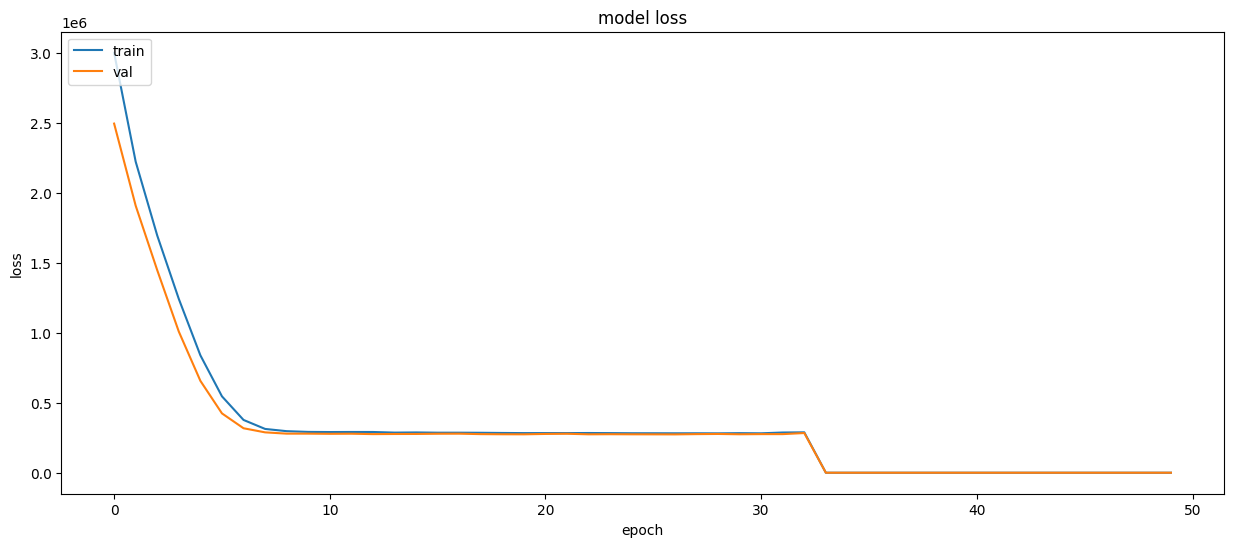

In [ ]:
plot_losses(train_losses, val_losses)

Reentrenamos con la totalidad de los datos de entrenamiento

In [ ]:
modelo_univariado_ventana_onepass = PronosticoUnivariado(ventana_futura=7)
modelo_univariado_ventana_onepass, train_losses = train_model(modelo_univariado_ventana_onepass,
                                                   dataset_train,
                                                   train_batch_size=32, learning_rate = 0.0015, epocas=50,
                                                   loss_fn=nn.MSELoss(), val_split=0,
                                                   early_stopping_loss_val_patience=5, verbose=True)

0:  loss: 1728103.409091 -- epoch time: 0.29
Se mejoró el train loss de inf a 1728103.4090909092
1:  loss: 586932.927273 -- epoch time: 0.27
Se mejoró el train loss de 1728103.4090909092 a 586932.9272727272
2:  loss: 320774.920909 -- epoch time: 0.30
Se mejoró el train loss de 586932.9272727272 a 320774.9209090909
3:  loss: 290454.361364 -- epoch time: 0.30
Se mejoró el train loss de 320774.9209090909 a 290454.3613636364
4:  loss: 288942.657841 -- epoch time: 0.29
Se mejoró el train loss de 290454.3613636364 a 288942.6578409091
5:  loss: 287684.759716 -- epoch time: 0.29
Se mejoró el train loss de 288942.6578409091 a 287684.7597159091
6:  loss: 285955.297273 -- epoch time: 0.31
Se mejoró el train loss de 287684.7597159091 a 285955.2972727273
7:  loss: 285519.674034 -- epoch time: 0.29
Se mejoró el train loss de 285955.2972727273 a 285519.6740340909
8:  loss: 284527.738352 -- epoch time: 0.28
Se mejoró el train loss de 285519.6740340909 a 284527.7383522727
9:  loss: 283191.571648 -- epo

Creamos una función para predecir los valores usando el modelo entrenado y compararlos con los reales.

In [ ]:
def eval(modelo, dataset, batch_size=64):
    preds = []
    modelo.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    eval_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in loader:
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE).float()
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            eval_loss += loss.item() * batch_labels.size(0)
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            preds.append(batch_preds.cpu().numpy())
    # se normalizan el loss y el accuracy del val set
    eval_loss /= len(loader.dataset)

    return eval_loss, np.concatenate(preds)

Con este modelo podemos entonces pronosticar sobre el test set y comparar los resultados.

In [ ]:
test_loss, test_preds = eval(modelo_univariado_ventana_onepass, dataset_test)
test_preds.shape

(309, 7)

In [ ]:
math.sqrt(test_loss)

454.4500478324533

In [ ]:
def plot_losses(real, preds):
    fig = plt.figure(figsize=(18,6))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(real)
    ax.plot(preds)
    plt.legend(['real', 'preds'], loc='upper left')
    plt.title('Real values')
    plt.ylabel('energy consumption in kw')
    plt.xlabel('days')
    plt.title('Forecasts')

    _=plt.show()

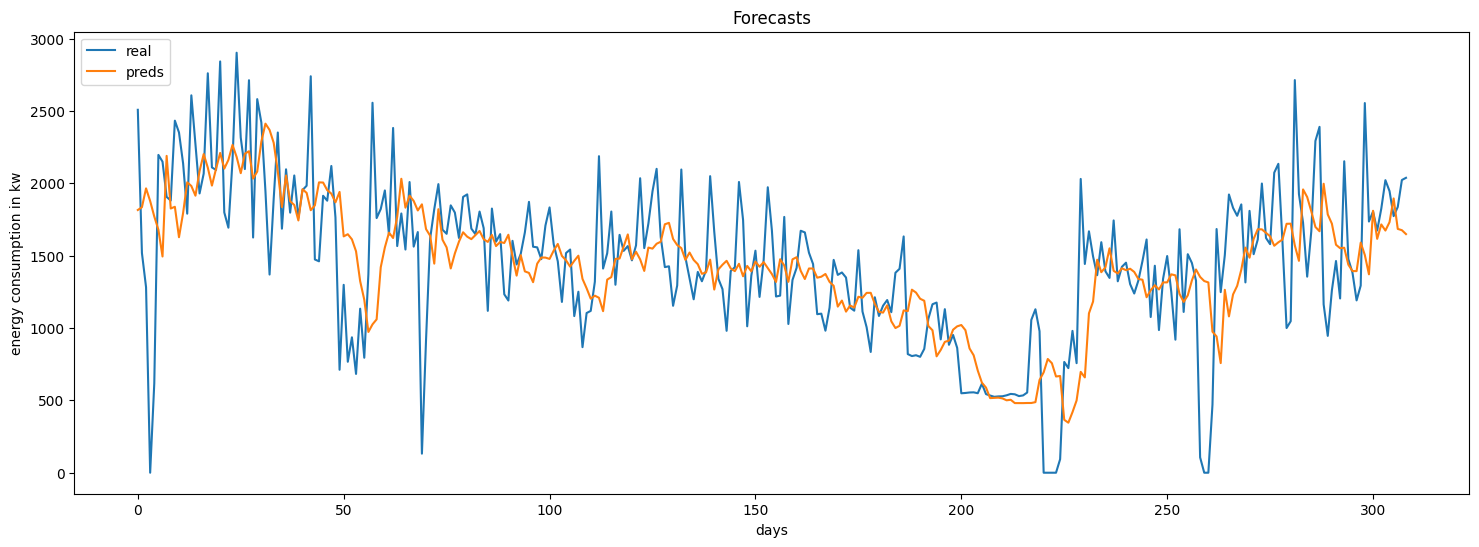

In [ ]:
plot_losses(dataset_test.get_labels().numpy()[:, 0], test_preds[:, 0])

# 4. Modelado univariado de pronóstico de paso de tiempo futuro sencillo

Vamos ahora a crear un modelo que dados los 7 días anteriores de la primera variable, pronostique el valor del siguiente día

In [ ]:
past_history = 7 # La última semana
future_target = 1 # Queremos predecir el valor del día siguiente
STEP = 1 # Queremos todos los días sin saltos
primer_dia = 1
ultimo_dia = 1113
dataset_train = SerieTiempoMultivariadaDataset(dataset=daily_data.iloc[primer_dia:ultimo_dia+1, 0:1], target=daily_data.iloc[primer_dia:ultimo_dia+1, 0],
                                                 history_size=past_history, target_size=future_target,
                                                 step=STEP, single_step=False)

In [ ]:
past_history = 7 # La última semana
future_target = 1 # Queremos predecir el valor del día siguiente
STEP = 1 # Queremos todos los días sin saltos
primer_dia = 1114
ultimo_dia = len(daily_data) - 1
dataset_test = SerieTiempoMultivariadaDataset(dataset=daily_data.iloc[primer_dia:ultimo_dia+1, 0:1], target=daily_data.iloc[primer_dia:ultimo_dia+1, 0],
                                                 history_size=past_history, target_size=future_target,
                                                 step=STEP, single_step=False)

In [ ]:
dataset_train[0]

(tensor([[3390.4600, 2203.8259, 1666.1940, 2225.7480, 1716.6240, 2341.3379,
          4773.3862]]),
 tensor([2550.0120]))

In [ ]:
len(dataset_train)

1106

In [ ]:
modelo_univariado_single_step = PronosticoUnivariado(ventana_futura=1)
best_model, train_losses, val_losses = train_model(modelo_univariado_single_step,
                                                   dataset_train,
                                                   train_batch_size=32, learning_rate = 0.0015, epocas=50,
                                                   loss_fn=nn.MSELoss(), val_split=0.3,
                                                   early_stopping_loss_val_patience=5, verbose=True)

val_split: 0.3, num_training_instances 774, num_validation_instances 332
0:  loss: 2301470.377261, val loss: 1686080.326807 -- epoch time: 0.41
Se mejoró el val loss de inf a 1686080.3268072288
1:  loss: 1268715.509690, val loss: 604867.957078 -- epoch time: 0.41
Se mejoró el val loss de 1686080.3268072288 a 604867.9570783132
2:  loss: 391801.306848, val loss: 250792.099021 -- epoch time: 0.37
Se mejoró el val loss de 604867.9570783132 a 250792.09902108434
3:  loss: 267043.183220, val loss: 246924.943901 -- epoch time: 0.37
Se mejoró el val loss de 250792.09902108434 a 246924.9439006024
4:  loss: 262332.446604, val loss: 244812.318901 -- epoch time: 0.40
Se mejoró el val loss de 246924.9439006024 a 244812.3189006024
5:  loss: 261014.336684, val loss: 244738.245858 -- epoch time: 0.45
Se mejoró el val loss de 244812.3189006024 a 244738.24585843374
6:  loss: 260963.736717, val loss: 245087.117470 -- epoch time: 0.40
7:  loss: 257823.323008, val loss: 242115.228916 -- epoch time: 0.39
Se 

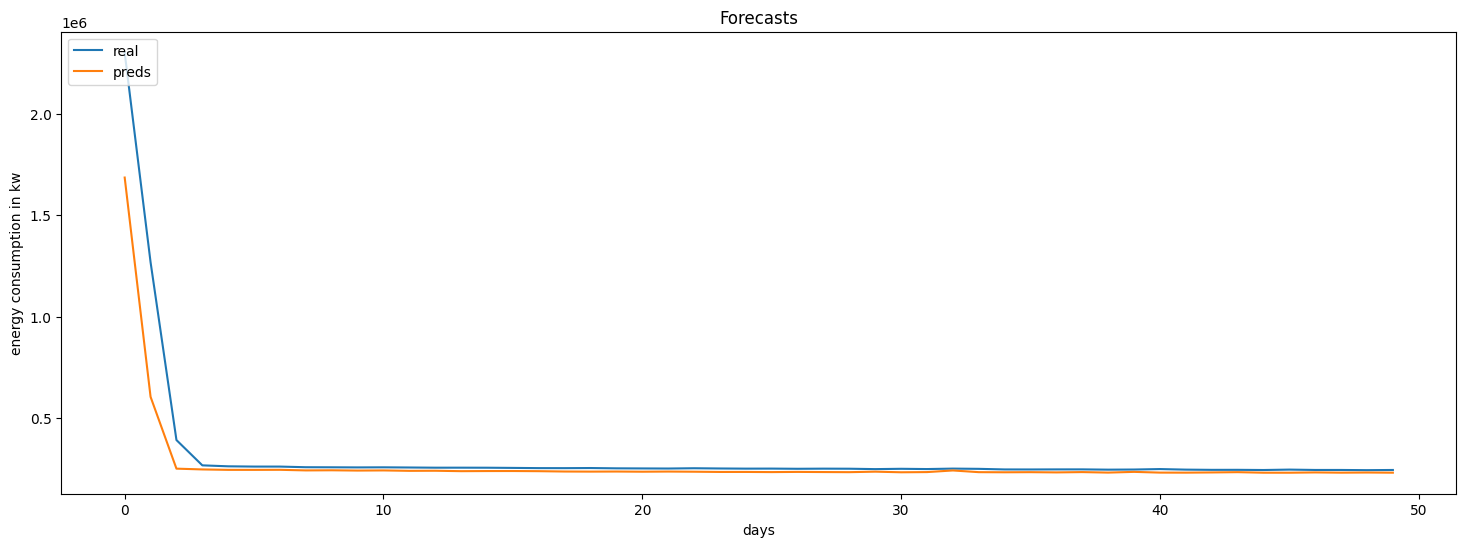

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
test_loss, test_preds = eval(modelo_univariado_single_step, dataset_test)
test_preds.shape

(321, 1)

In [ ]:
math.sqrt(test_loss)

442.68168228832934

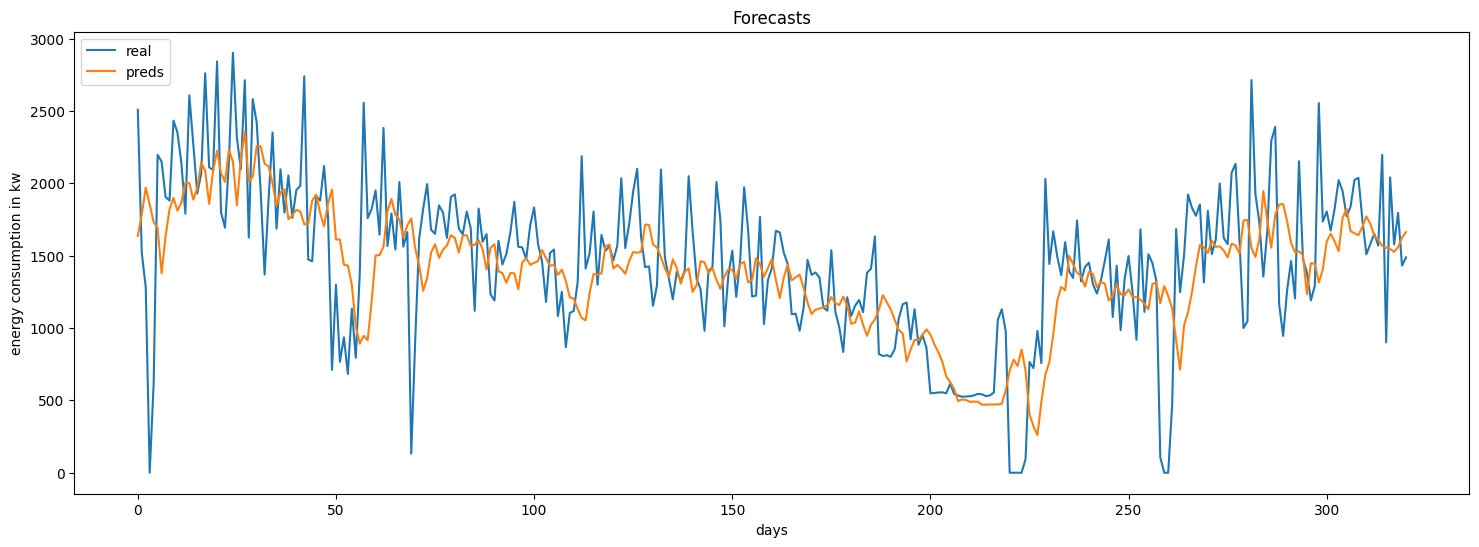

In [ ]:
plot_losses(dataset_test.get_labels().numpy()[:, 0], test_preds[:, 0])